# Проект дашборд конверсий

### Задачи для предварительного анализа данных:ribe

* Склонируйте созданный репозиторий проекта на рабочую машину
* Создайте Jypyter Notebook и подключите необходимые библиотеки (pandas, requests)
* Запросите данные по API за период 2023-03-01 -> 2023-09-01
* Изучите данные, сделайте предварительный анализ с помощью dataframe.describe

Импортируем необходимые библиотеки:

In [150]:
import pandas as pd
import requests
import os
from dotenv import load_dotenv

Первая регистрация была соверешна в первый день 01.03.2023, более половины было зарегистрировано 03.03.2023 и большая часть до 04.03.2023

In [151]:
# Получаем текущую директорию
current_directory = os.getcwd()

# Создаем путь к папке charts в текущей директории
charts_directory = os.path.join(current_directory, 'charts')

# Проверяем, существует ли папка charts; если нет, создаем ее
if not os.path.exists(charts_directory):
    os.makedirs(charts_directory)
    print(f"Папка 'charts' создана в {current_directory}")
else:
    print(f"Папка 'charts' уже существует в {current_directory}")

Папка 'charts' уже существует в C:\Users\VTB\Desktop\Project 3\1


Запросим данные по API за период 2023-03-01 -> 2023-09-01 сначала по входам, потом по регистрациям

In [155]:
load_dotenv()  # загружаются переменные из файла

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_BEGIN = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

resp = requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_BEGIN})

In [86]:
# Фильтрация визитов от ботов
visits_df = df_visits[df_visits['user_agent'] != 'bot']
print(visits_df)

                             datetime platform  \
0       Wed, 01 Mar 2023 10:36:22 GMT      web   
1       Wed, 01 Mar 2023 06:25:00 GMT      web   
2       Wed, 01 Mar 2023 10:26:13 GMT      web   
3       Wed, 01 Mar 2023 12:33:06 GMT      web   
4       Wed, 01 Mar 2023 01:38:35 GMT      web   
...                               ...      ...   
263454  Tue, 29 Aug 2023 10:43:29 GMT      web   
263455  Tue, 29 Aug 2023 19:29:16 GMT      web   
263456  Tue, 29 Aug 2023 12:51:11 GMT      web   
263457  Tue, 29 Aug 2023 21:45:08 GMT      web   
263458  Wed, 30 Aug 2023 19:19:04 GMT      web   

                                               user_agent  \
0       Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
1       Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...   
2       Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...   
3       Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...   
4       Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
...                              

In [156]:
load_dotenv()  # загружаются переменные из файла

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_BEGIN = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

resp = requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_BEGIN})

### В этом шаге расчитаем конверсию визитов в регистрации. На выходе у вас должен получиться датафрейм со следующими полями:


date_group — дата
platform — платформа: web, ios, android
visits — визиты в дату
registrations — регистрации в дату
conversion — конверсия
Среди визитов есть боты — это поисковые и SEO-боты, которые регулярно сканируют страницы. Определить их можно по слову bot в User-Agent.

Сагрегируем данные по дате и платформам. Также сохраним полученный датафрейм в формате JSON о платформе

### Требования

Данные должны быть отсортированы по дате, от ранних к более поздним
Визиты ботов не должны влиять на расчет конверсии.


### Задачи

Выполните Jupyter Notebook следующие задачи:
* Сгруппируйте данные визитов по датам и платформам
* Сгруппируйте также данные регистраций по датам и платформам
* Объедините датайфреймы, сделайте итоговый датафрейм с расчетом конверсии
* Сохраните датафрейм в формате JSON conversion.json
  
Поля датафрейма:
* date_group - сагрегированный столбец дат
* platform - платформа (android,web,ios)
* visits - визиты за период date_group
* registrations - регистрации за период date_group
* conversion - конверсия по платформе

### Подсказки

Пользователи могли заходить на сайт несколько раз, прежде чем зарегистрироваться. Учтите это и возьмите только последний визит для каждого visit_id
Для сохранения датафрейма в JSON используйте метод .to_json(./conversion.json)
Пример JSONа: json { "date_group": { "0": 1677628800000, "1": 1677628800000, }, "platform": { "0": "android", "1": "ios", }, "visits": { "0": 158, "1": 70, }, "registrations": { "0": 120, "1": 59, }, "conversion": { "0": 75.9493670886, "1": 84.2857142857, } }

Сгруппируем данные визитов по датам и платформам

In [88]:
# Найдем последние визиты всех пользователей
visits_df['datetime'] = pd.to_datetime(visits_df['datetime'], format='%a, %d %b %Y %H:%M:%S GMT')

df = visits_df.sort_values(by='datetime', ascending=False)

latest_visits = df.groupby('visit_id').first().reset_index()

latest_visits['date_group'] = latest_visits['datetime'].dt.date

visits_grouped = latest_visits.groupby(['date_group', 'platform']).size().reset_index(name='visits')

print(visits_grouped)

     date_group platform  visits
0    2023-03-01  android      75
1    2023-03-01      ios      22
2    2023-03-01      web     279
3    2023-03-02  android      67
4    2023-03-02      ios      31
..          ...      ...     ...
589  2023-08-30      ios      66
590  2023-08-30      web    1227
591  2023-08-31  android      57
592  2023-08-31      ios      50
593  2023-08-31      web     721

[594 rows x 3 columns]


Сгруппируйте также данные регистраций по датам и платформам

In [89]:
# Преобразуем строку в формат datetime
registrations_df['datetime'] = pd.to_datetime(registrations_df['datetime'])

# Извлечем кусок даты
registrations_df['date_group'] = registrations_df['datetime'].dt.date

# Сгруппируем данные по дате и платформе
registrations_grouped = registrations_df.groupby(['date_group', 'platform']).size().reset_index(name='registrations')
print(registrations_grouped)

     date_group platform  registrations
0    2023-03-01  android             61
1    2023-03-01      ios             18
2    2023-03-01      web              8
3    2023-03-02  android             59
4    2023-03-02      ios             24
..          ...      ...            ...
547  2023-08-30      ios             40
548  2023-08-30      web             34
549  2023-08-31  android             42
550  2023-08-31      ios             36
551  2023-08-31      web             46

[552 rows x 3 columns]


Объединим датафреймы

In [90]:
merged_df = pd.merge(visits_grouped, registrations_grouped, on=['date_group', 'platform'], how='inner')
print(merged_df)

     date_group platform  visits  registrations
0    2023-03-01  android      75             61
1    2023-03-01      ios      22             18
2    2023-03-01      web     279              8
3    2023-03-02  android      67             59
4    2023-03-02      ios      31             24
..          ...      ...     ...            ...
547  2023-08-30      ios      66             40
548  2023-08-30      web    1227             34
549  2023-08-31  android      57             42
550  2023-08-31      ios      50             36
551  2023-08-31      web     721             46

[552 rows x 4 columns]


Заполним NaN значения нулями

In [91]:
merged_df['visits'] = merged_df['visits'].fillna(0)
merged_df['registrations'] = merged_df['registrations'].fillna(0)

Посчитаем конверсию

In [92]:
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits']).fillna(0)

Сохраним датафрейм в формате JSON

In [93]:
merged_df.to_json('conversion.json', orient='records', date_format='iso')

In [94]:
#print(merged_df)

Добавим данные по рекламным кампаниям

In [95]:
ads_df = pd.read_csv('./ads.csv')

В этом шаге добавим данные по рекламным кампаниям. На выходе получим датафрейм со следующими полями:

* date_group — дата
* visits — визиты в дату
* registrations — регистрации в дату
* cost — затраты на рекламу, 0 если не было затрат
* utm_campaign — название рекламной кампании, none если не было в этот период рекламы
Сагрегируем данные по дате и сохраним их в JSON

Описание CSV
CSV-таблица содержит записи следующего вида:

* date — дата проведения кампании
* utm_source — utm-источник: yandex, vk, google, youtube, tg
* utm_medium — utm-медиум: cpc или social
* utm_campaign — название кампании
* cost — затраты на рекламу

Требования
Данные должны быть отсортированы по дате, от ранних к более поздним

In [96]:
print(ads_df)

                    date utm_source utm_medium                utm_campaign  \
0    2023-03-01T10:54:41     google        cpc  advanced_algorithms_series   
1    2023-03-02T10:32:35     google        cpc  advanced_algorithms_series   
2    2023-03-03T19:21:40     google        cpc  advanced_algorithms_series   
3    2023-03-04T17:52:04     google        cpc  advanced_algorithms_series   
4    2023-03-05T05:35:13     google        cpc  advanced_algorithms_series   
..                   ...        ...        ...                         ...   
154  2023-09-13T05:34:02         vk     social      intro_to_python_course   
155  2023-09-14T18:25:13         vk     social      intro_to_python_course   
156  2023-09-15T15:35:47         vk     social      intro_to_python_course   
157  2023-09-16T05:30:26         vk     social      intro_to_python_course   
158  2023-09-17T02:04:39         vk     social      intro_to_python_course   

     cost  
0     212  
1     252  
2     202  
3     223  
4  

In [97]:
# Преобразуем строку в формат datetime
ads_df['date'] = pd.to_datetime(ads_df['date'])

# Извлечем кусок даты и поправим название колонки
ads_df['date_group'] = ads_df['date'].dt.date

In [98]:
# Агрегируем зараты на рекламу и кампании по датам в соответствии с требованиями
ads_aggregated = ads_df.groupby(['date_group']).agg({'cost': 'sum', 'utm_campaign': 'first'}).reset_index()

In [99]:
# Объединим таблицы
result_df = pd.merge(merged_df, ads_aggregated, on='date_group', how='left')

In [100]:
# Заполним пустые значения 0 для cost и none для utm_campaign
result_df['cost'].fillna(0)
result_df['utm_campaign'].fillna('none')

print(result_df)

     date_group platform  visits  registrations  conversion   cost  \
0    2023-03-01  android      75             61    0.813333  212.0   
1    2023-03-01      ios      22             18    0.818182  212.0   
2    2023-03-01      web     279              8    0.028674  212.0   
3    2023-03-02  android      67             59    0.880597  252.0   
4    2023-03-02      ios      31             24    0.774194  252.0   
..          ...      ...     ...            ...         ...    ...   
547  2023-08-30      ios      66             40    0.606061  109.0   
548  2023-08-30      web    1227             34    0.027710  109.0   
549  2023-08-31  android      57             42    0.736842  215.0   
550  2023-08-31      ios      50             36    0.720000  215.0   
551  2023-08-31      web     721             46    0.063800  215.0   

                   utm_campaign  
0    advanced_algorithms_series  
1    advanced_algorithms_series  
2    advanced_algorithms_series  
3    advanced_algorithm

In [101]:
# Сортируем по дате
result_df.sort_values(by='date_group', inplace=True)

In [102]:
# Сохраняем результат в JSON
result_df.to_json('ads.json', orient='records', date_format='iso')

В этом шаге визуализируем наши расчеты. Построим следующие графики в формате PNG:

* Итоговые визиты
* Итоговые визиты с разбивкой по платформам: web, android, ios
* Итоговые регистрации
* Итоговые регистрации с разбивкой по платформе: web, android, ios
* Конверсия по каждой платформе
* Средняя конверсия
* Стоимости реклам
* Визиты за весь период с цветовым выделением рекламной кампании
* Регистрации за весь период с цветовым выделением рекламной кампании

Задачи
Выполните Jupyter Notebook следующие задачи:

* Установите библиотеки для визуализации
* Постройте требуемые графики
* Сохраните их в PNG в директорию ./charts, например как plt.savefig('./charts/registrations_by_platform.png')

График с итоговыми визитами

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import plotly.express as px

In [104]:
filtered_df = result_df[(result_df['date_group'].astype(str) >= '2023-03-01') & (result_df['date_group'].astype(str) <= '2023-04-30')]

График **Итоговые визиты**

Напишем скрипт, которые проверит есть ли папка с charts и если её нет, то создаст её.

In [105]:
# Путь к папке, куда нужно сохранить график
save_folder = '../charts'

# Проверяем существование папки, если её нет - создаем
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

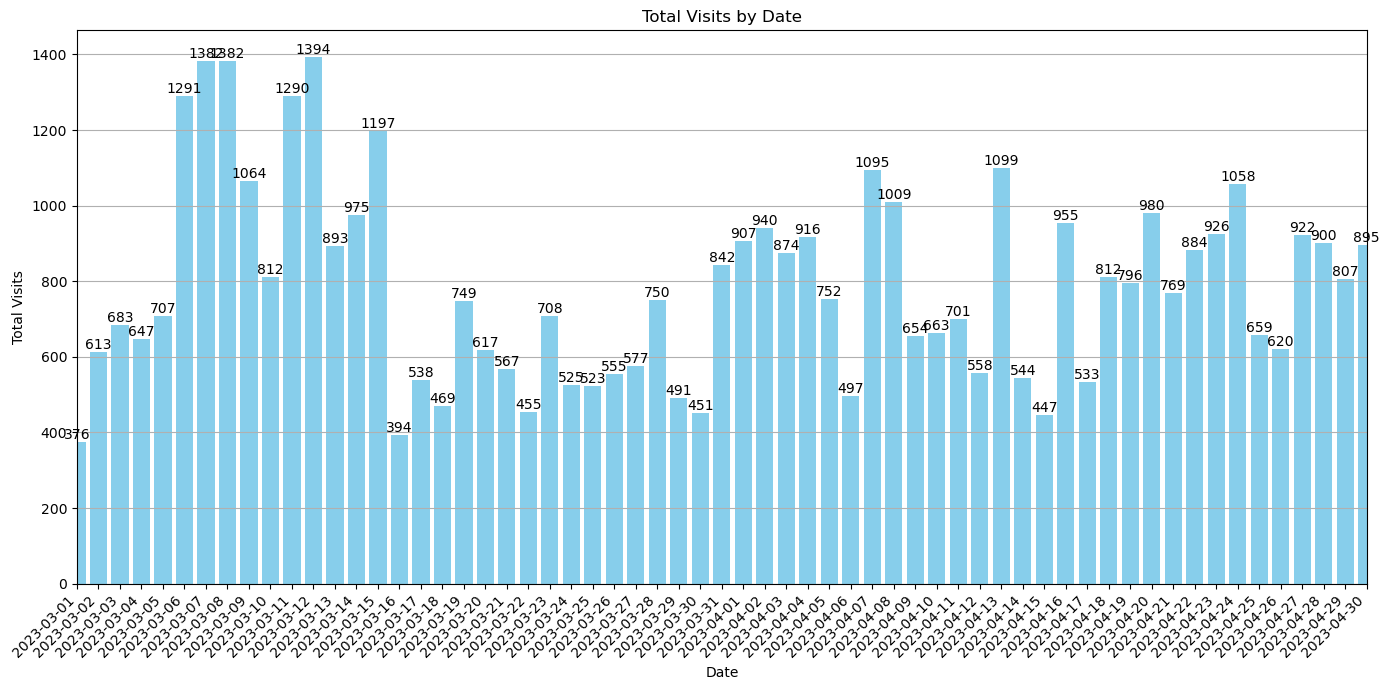

In [106]:
grouped_data = filtered_df.groupby('date_group')['visits'].sum().reset_index()

plt.figure(figsize=(14, 7))
bars = plt.bar(grouped_data['date_group'], grouped_data['visits'], color='skyblue')
plt.xlabel('Date')
plt.ylabel('Total Visits')
plt.title('Total Visits by Date')
plt.xticks(grouped_data['date_group'], rotation=45, ha='right')
plt.grid(axis='y')

plt.xlim(min(grouped_data['date_group']), max(grouped_data['date_group']))


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()

График **Итоговые визиты с разбивкой по платформам: web, android, ios**

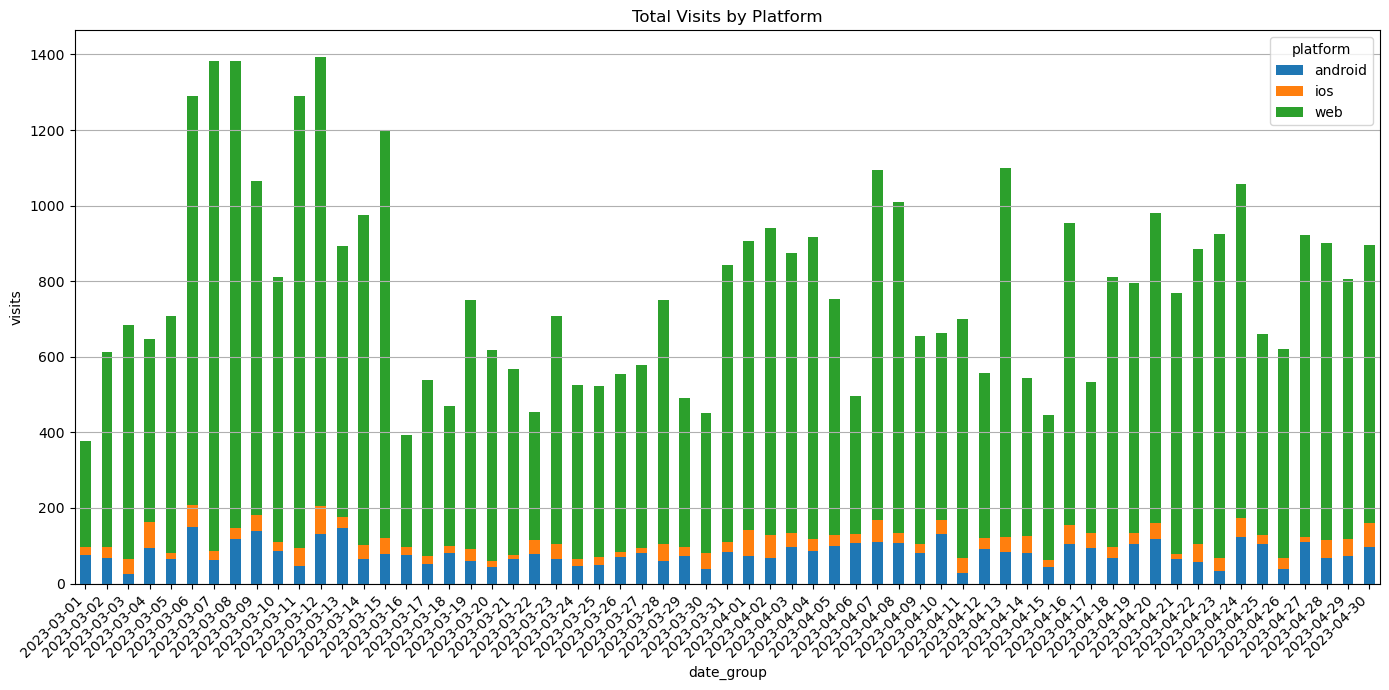

In [107]:
pivot_df = filtered_df.pivot_table(values='visits', index='date_group', columns='platform', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(14, 7))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel('date_group')
ax.set_ylabel('visits')
ax.set_title('Total Visits by Platform')
plt.xticks(filtered_df['date_group'], rotation=45, ha='right')
ax.set_xticks(range(len(pivot_df.index)))

# Устанавливаем пределы оси x, чтобы убрать пустое место перед первым столбцом и после последнего
ax.set_xlim(-0.5, len(pivot_df.index)-0.5)

ax.grid(axis='y')

plt.tight_layout()
plt.savefig(os.path.join(charts_directory, 'total_visits_by_platform.png'))
plt.show()

График **Итоговые регистрации**


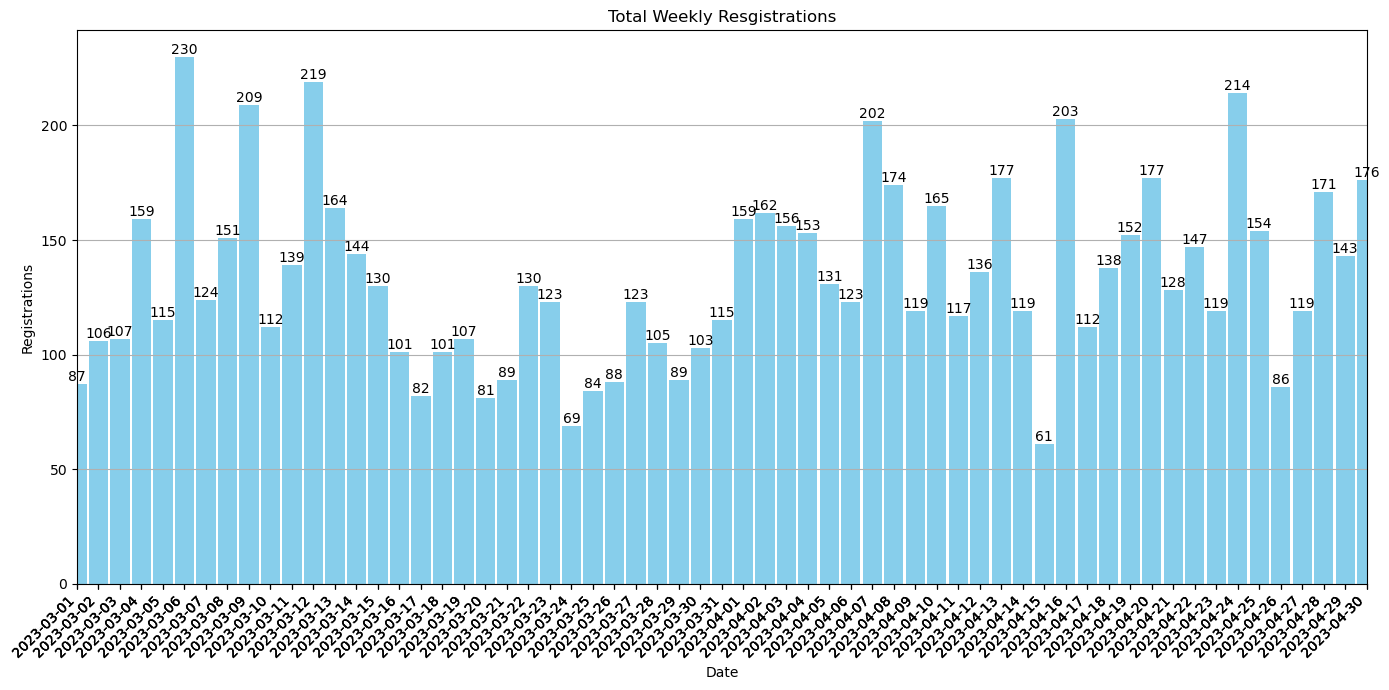

In [112]:
filtered_df_registrations = filtered_df.groupby('date_group')['registrations'].sum().reset_index()

plt.figure(figsize=(14, 7))
bars = plt.bar(filtered_df_registrations['date_group'], filtered_df_registrations['registrations'], color='skyblue', width=0.9)
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.title('Total Weekly Resgistrations')
plt.xticks(filtered_df['date_group'], rotation=45, ha='right')
plt.grid(axis='y')

plt.xlim(min(grouped_data['date_group']), max(grouped_data['date_group']))

# Добавляем подписи к столбикам по количеству регистраций
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.savefig(os.path.join(charts_directory, 'total_registrations.png'))
plt.show()

График **Итоговые регистрации с разбивкой по платформе: web, android, ios**

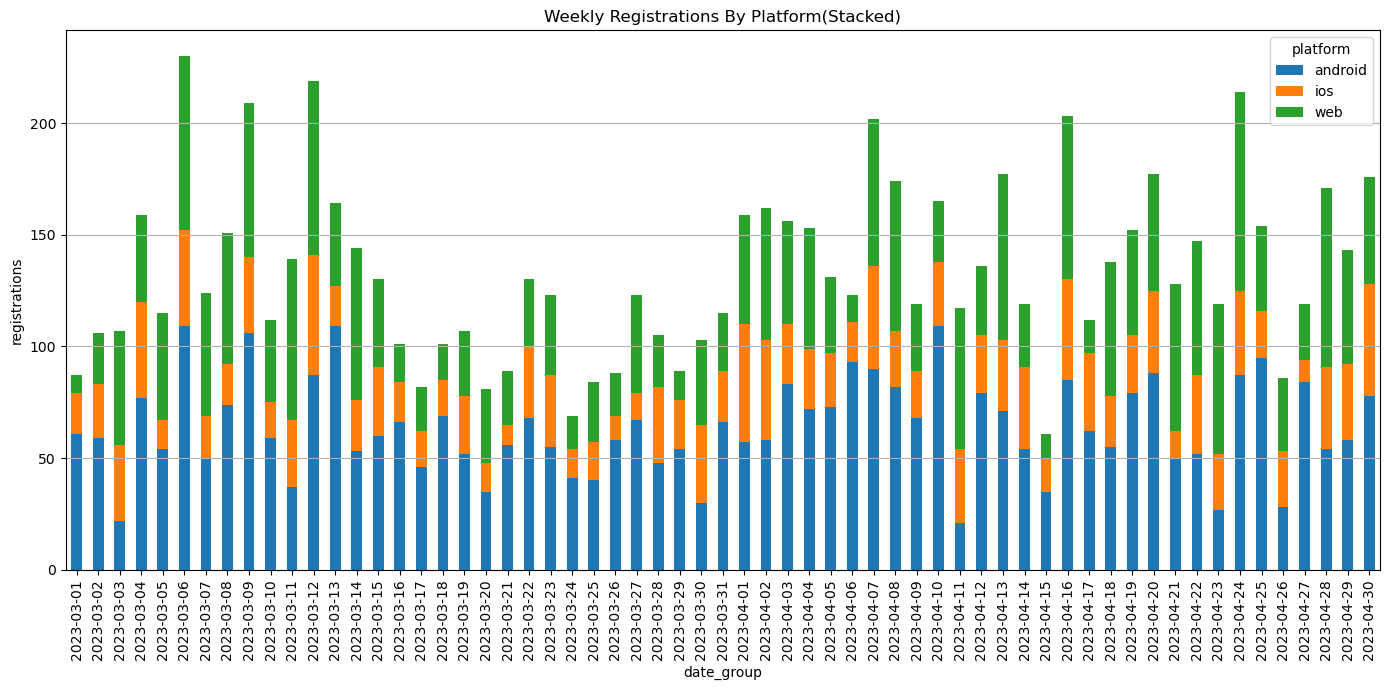

In [113]:
filtered_df = result_df[(result_df['date_group'].astype(str) >= '2023-03-01') & (result_df['date_group'].astype(str) <= '2023-04-30')]

# Преобразуем данные так, чтобы получить сумму посещений для каждой платформы в каждую дату
pivot_df = filtered_df.pivot_table(values='registrations', index='date_group', columns='platform', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(14, 7))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel('date_group')
ax.set_ylabel('registrations')
ax.set_title('Weekly Registrations By Platform(Stacked)')
ax.set_xticks(range(len(pivot_df.index)))

# Устанавливаем пределы оси x, чтобы убрать пустое место перед первым столбцом и после последнего
ax.set_xlim(-0.5, len(pivot_df.index)-0.5)

ax.grid(axis='y')

plt.tight_layout()
plt.savefig(os.path.join(charts_directory, 'total_registrations_by_platform.png'))
plt.show()

График **Конверсия по каждой платформе**

In [114]:
filtered_df_conversion = result_df[(result_df['date_group'].astype(str) >= '2023-03-01') & (result_df['date_group'].astype(str) <= '2023-05-01')]

# Отфильтруем 3 датасета по каждой из платформ
android_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'android']
android_df.loc[:, 'conversion'] = android_df['conversion'] * 100

ios_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'ios']
ios_df.loc[:, 'conversion'] = ios_df['conversion'] * 100

web_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'web']
web_df.loc[:, 'conversion'] = web_df['conversion'] * 100

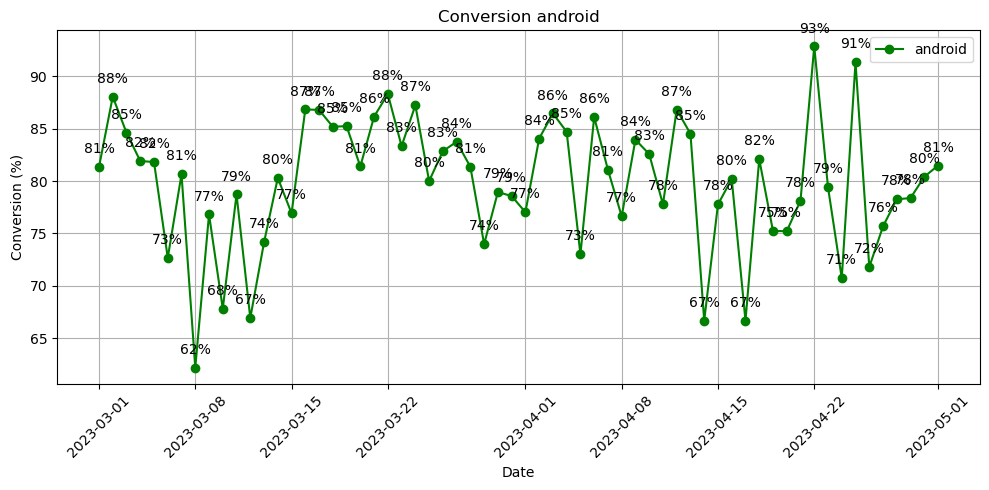

In [115]:
plt.figure(figsize=(10, 5))
plt.plot(android_df['date_group'], android_df['conversion'], marker='o', linestyle='-', color='green', label='android')

for i, txt in enumerate(android_df['conversion']):
    plt.annotate(f'{txt:.0f}%', (android_df['date_group'].iloc[i], android_df['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Conversion android')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(charts_directory, 'conversion_android.png'))
plt.show()

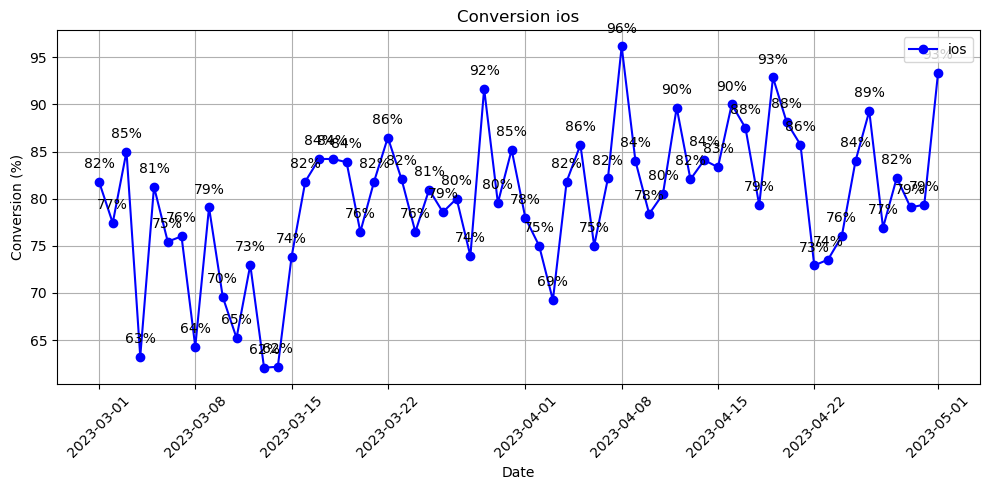

In [116]:
plt.figure(figsize=(10, 5))
plt.plot(ios_df['date_group'], ios_df['conversion'], marker='o', linestyle='-', color='blue', label='ios')

for i, txt in enumerate(ios_df['conversion']):
    plt.annotate(f'{txt:.0f}%', (ios_df['date_group'].iloc[i], ios_df['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')


plt.title('Conversion ios')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(charts_directory, 'conversion_ios.png'))
plt.show()

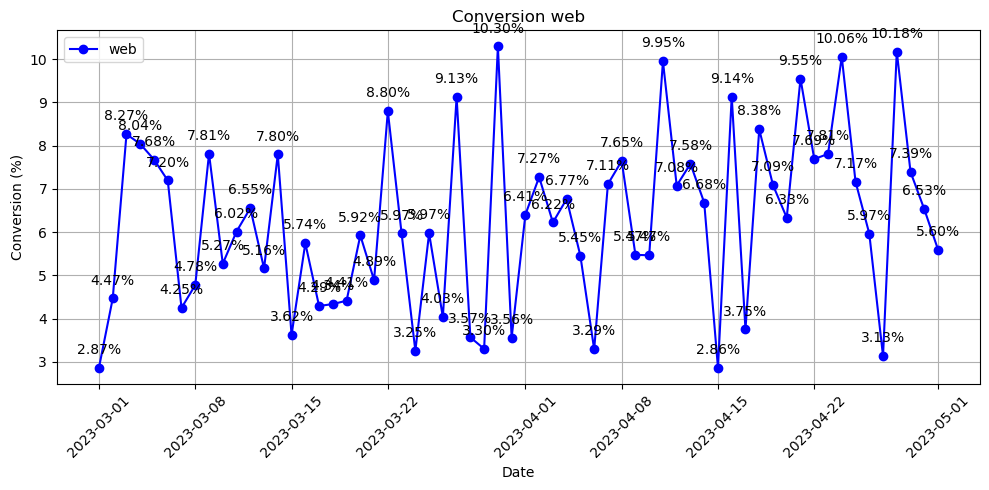

In [117]:
plt.figure(figsize=(10, 5))
plt.plot(web_df['date_group'], web_df['conversion'], marker='o', linestyle='-', color='blue', label='web')

for i, txt in enumerate(web_df['conversion']):
    plt.annotate(f'{txt:.2f}%', (web_df['date_group'].iloc[i], web_df['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')


plt.title('Conversion web')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(charts_directory, 'conversion_web.png'))
plt.show()

График **Средняя конверсия**

In [118]:
# Преобразование столбца даты в формат datetime
result_df['date_group'] = pd.to_datetime(result_df['date_group'])

# Извлечение года и месяца и добавление их в отдельные столбцы
result_df['year_month'] = result_df['date_group'].dt.to_period('M')

# Группировка данных по годам и месяцам и расчет средней конверсии за месяц
monthly_avg_conversion = result_df.groupby('year_month')['conversion'].mean().reset_index()

# Преобразование конверсии в проценты
monthly_avg_conversion['conversion'] = monthly_avg_conversion['conversion'] * 100

print(monthly_avg_conversion)

  year_month  conversion
0    2023-03   54.393995
1    2023-04   56.141959
2    2023-05   55.724333
3    2023-06   52.521314
4    2023-07   46.178133
5    2023-08   52.152266


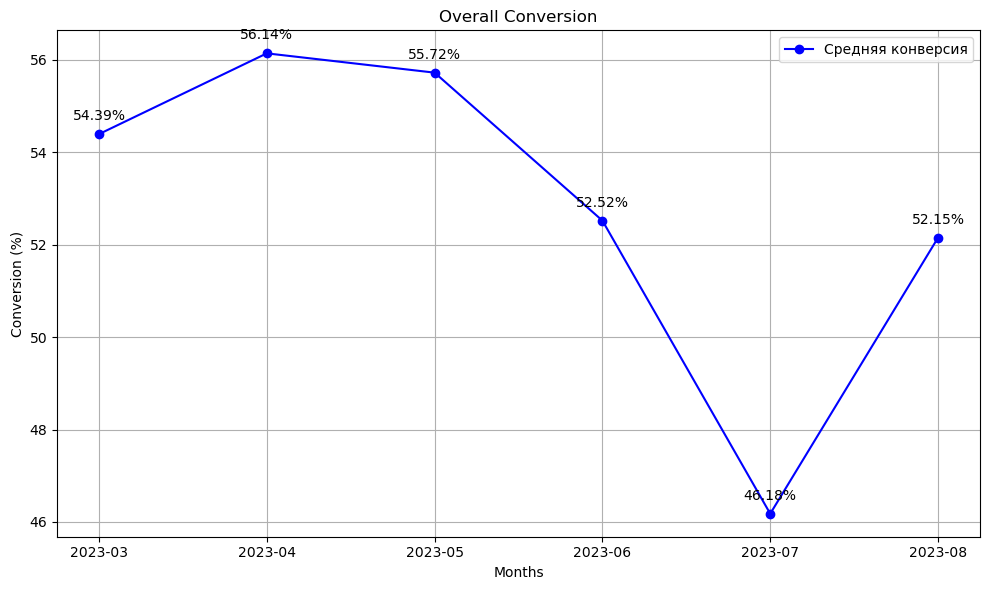

In [119]:
monthly_avg_conversion['year_month'] = monthly_avg_conversion['year_month'].astype(str)

plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_conversion['year_month'], monthly_avg_conversion['conversion'], marker='o', linestyle='-', color='b', label='Средняя конверсия')

for i, txt in enumerate(monthly_avg_conversion['conversion']):
    plt.annotate(f'{txt:.2f}%', (monthly_avg_conversion['year_month'][i], monthly_avg_conversion['conversion'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Months')
plt.ylabel('Conversion (%)')
plt.title('Overall Conversion')
plt.grid(True) 
plt.legend() 

plt.tight_layout()
plt.savefig(os.path.join(charts_directory, 'overall_conversion.png'))
plt.show()

График **Стоимости реклам**

In [145]:
result_df['date_group'] = pd.to_datetime(result_df['date_group'])

mask = (result_df['date_group'] >= '2023-03-01') & (result_df['date_group'] <= '2023-04-30')
filtered_df_costs = result_df.loc[mask]

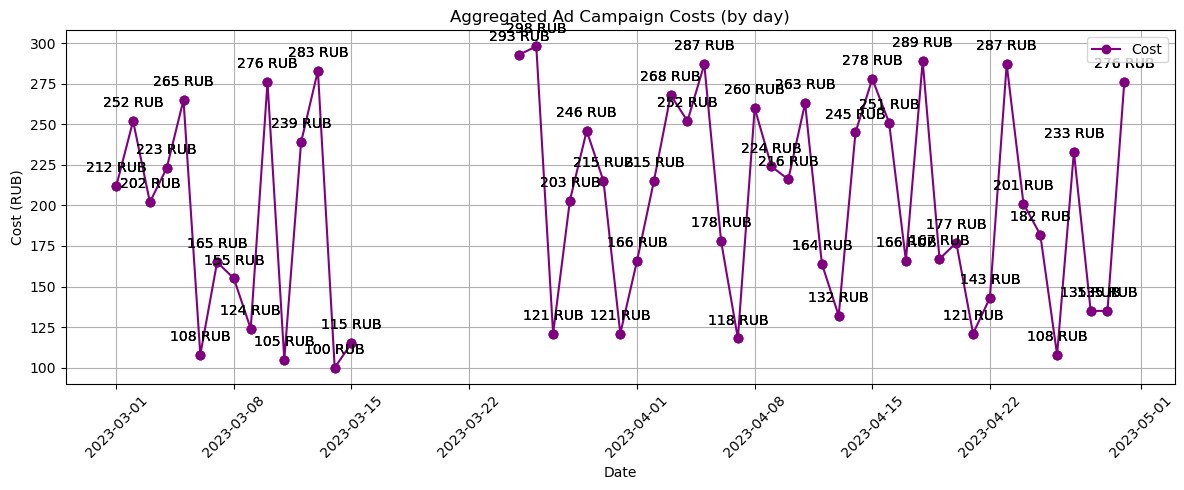

In [123]:
plt.figure(figsize=(12, 5))
plt.plot(filtered_df_costs['date_group'], filtered_df_costs['cost'], marker='o', linestyle='-', color='purple', label='Cost')

for i, txt in enumerate(filtered_df_costs['cost']):
    plt.annotate(f'{txt:.0f} RUB', (filtered_df_costs['date_group'].iloc[i], filtered_df_costs['cost'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Aggregated Ad Campaign Costs (by day)')
plt.xlabel('Date')
plt.ylabel('Cost (RUB)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(os.path.join(charts_directory, 'aggregated_ad_campaign_costs.png'))
plt.show()

График **Визиты за весь период с цветовым выделением рекламной кампании** и **Регистрации за весь период с цветовым выделением рекламной кампании**

In [124]:
import matplotlib.dates as mdates

C:\Users\VTB\AppData\Local\Temp\ipykernel_9968\2764764365.py:41: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(handles.values(), labels=[h.get_label() for h in handles.values()], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)


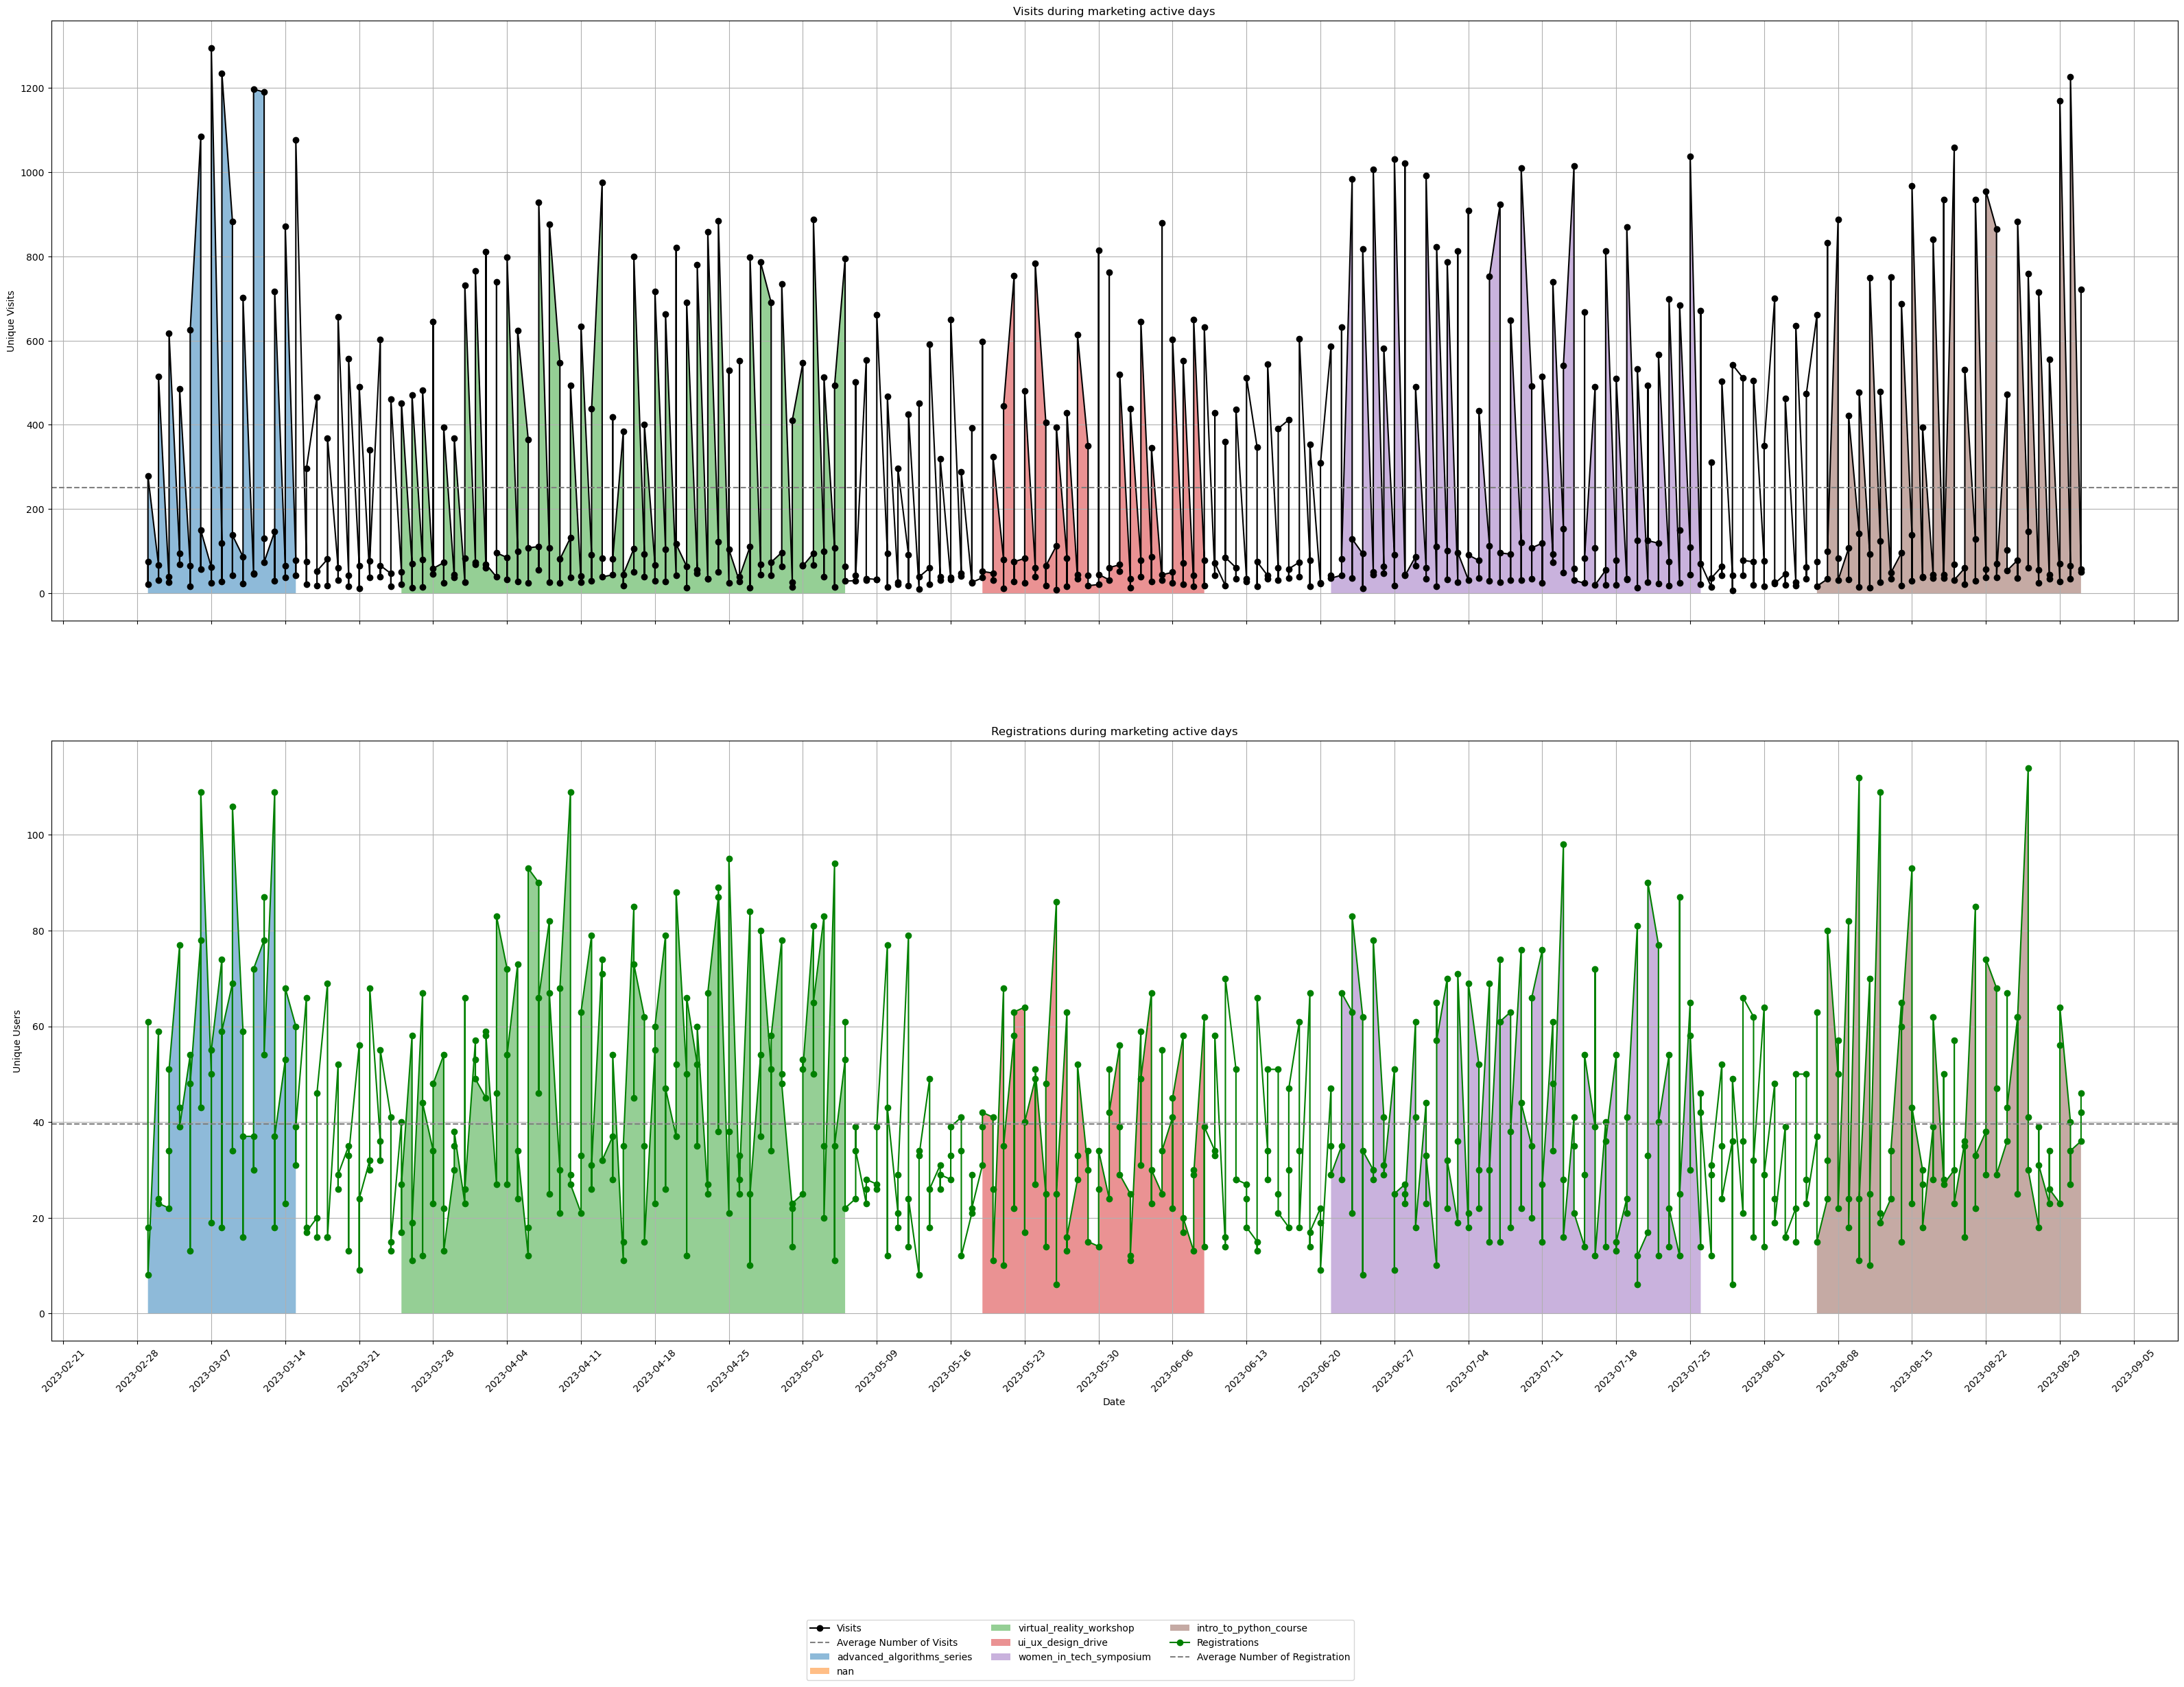

In [148]:
unique_campaigns = result_df[result_df['utm_campaign'] != 0]['utm_campaign'].unique()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40, 25), sharex=True)

handles, labels = {}, {}

# График визитов
visits_line, = ax1.plot(result_df['date_group'], result_df['visits'], marker='o', linestyle='-', color='black', label='Visits')
visits_mean = ax1.axhline(result_df['visits'].mean(), color='gray', linestyle='--', label='Average Number of Visits')
handles.update({visits_line.get_label(): visits_line, visits_mean.get_label(): visits_mean})

for campaign in unique_campaigns:
    campaign_mask = result_df['utm_campaign'] == campaign
    fill = ax1.fill_between(result_df['date_group'], result_df['visits'], where=campaign_mask, alpha=0.5, label=campaign)
    handles.update({campaign: fill})
ax1.set_ylabel('Unique Visits')
ax1.set_title('Visits during marketing active days')
ax1.grid(True)

# График регистраций
registrations_line, = ax2.plot(result_df['date_group'], result_df['registrations'], marker='o', linestyle='-', color='green', label='Registrations')
registrations_mean = ax2.axhline(result_df['registrations'].mean(), color='gray', linestyle='--', label='Average Number of Registration')
handles.update({registrations_line.get_label(): registrations_line, registrations_mean.get_label(): registrations_mean})

for campaign in unique_campaigns:
    campaign_mask = result_df['utm_campaign'] == campaign
    fill = ax2.fill_between(result_df['date_group'], result_df['registrations'], where=campaign_mask, alpha=0.5, label=campaign)
    handles.update({campaign: fill})
ax2.set_ylabel('Unique Users')
ax2.set_title('Registrations during marketing active days')
ax2.grid(True)

# Настройка оси X
ax2.set_xlabel('Date')
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Расположение общей легенды
fig.legend(handles.values(), labels=[h.get_label() for h in handles.values()], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.savefig(os.path.join(charts_directory, 'v_and_re_during_marketing_active_days.png'))
plt.show()

Настроем переменные окружения